# POSTPROCESSING OF LOSS MEASUREMENTS



## Extract from Excel

In [92]:
#read the files from BST-L
import pandas as pd
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
import matplotlib.pyplot as plt

# File paths
file_paths = {
    "A": "LAMS/LAMS/20Hz-2kHz_BMT4679_LAM#1_Alvier_21407_BST-SA 20Hz-2kHz_H.xlsx",
    "B": "LAMS/LAMS/20Hz-2kHz_BMT4680_LAM#2_Alvier_21407_BST-SA 20Hz-2kHz_H.xlsx",
    "C": "LAMS/LAMS/20Hz-2kHz_BMT4681_LAM#3_Alvier_21407_BST-SA 20Hz-2kHz_H.xlsx"
}

# Read the Excel files and inspect the first few rows
data_samples = {}
for ids, path in file_paths.items():
    data_samples[ids] = pd.read_excel(path, None)  # Read all sheets

# Display sheet names for each file
sheet_names = {ids: list(data.keys()) for ids, data in data_samples.items()}
sheet_names

{'A': ['Common', 'Results', 'DataPoints', 'DebugInfos'],
 'B': ['Common', 'Results', 'DataPoints', 'DebugInfos'],
 'C': ['Common', 'Results', 'DataPoints', 'DebugInfos']}

In [93]:
# Inspect the "DataPoints" sheet in one file to determine relevant columns
data_points_sample = data_samples["A"]["Results"].head()
data_points_sample

,Measurement,Coil system,Sample,Direction,Signal form,Nominal,Frequency [Hz],Jmax [T],Hmax [A/m],Ps [W/kg],...,Points,E [mJ/kg],µMax,Uflux [V],Tension [MPa],Booster,Status,"Regulator (State|Reverse Pol.|Att,Cap|P|I|OEK|ORW)",Corr.,
0,1.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.6 T,20.0,1.600623,3464.514102,1.130664,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN
1,2.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.5 T,20.0,1.498869,1818.961056,0.969463,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN
2,3.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.4 T,20.0,1.400059,963.479111,0.844272,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN
3,4.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.3 T,20.0,1.316826,655.603326,0.751586,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN
4,5.0,BST-SA_48_4,BMT4679_LAM#1,NaN,Sin,1.2 T,20.0,1.192322,459.990633,0.638442,...,0.0,0.0,0.0,0.0,0.0,1.0,Found,Dig|Cur:False|0.003|0.006|0.003|0.006|0.001|32...,1.0,NaN


In [94]:
# Average the core loss results relative to the same J and frequency across the excel files
#  Collect all Results data into a single DataFrame with an identifier
results_list = []
for key, sample in data_samples.items():
    df = sample["Results"].copy()
    df["Sample"] = key  # Add a column to identify the source
    results_list.append(df)

# Concatenate all Results data
all_results = pd.concat(results_list, ignore_index=True)

# Remove ' T' from Nominal column if present
all_results['Nominal'] = all_results['Nominal'].astype(str).str.replace(' T', '', regex=False)

# Group by 'Nominal' and 'Frequency [Hz]', then average 'Ps [W/kg]'
res_avg = all_results.groupby(['Nominal', 'Frequency [Hz]'])['Ps [W/kg]'].mean().reset_index()

# Ensure all columns are numeric for optimization
result_avg = res_avg.dropna().astype(float).values


## Optimization definition 

In [95]:
def run_optimization(result_avg, pop_size, n_iter, algorithm_name="CMAES", weight= False):
    """
    Run optimization for the Bertotti core loss model.
    algorithm_name: str, one of ["CMAES", "DE"]
    """
    from pymoo.optimize import minimize
    from pymoo.core.problem import Problem
    import numpy as np
    import matplotlib.pyplot as plt

    # Setup Optimization Problem 
    class loss_opt(Problem):
        def __init__(self, result_avg):
            super().__init__(
                n_var=6,
                n_obj=1,
                n_constr=0,
                # Variable bounds 
                # K_hyst, K_eddy, alpha, beta, gamma, delta  
                xl=np.array([1e-6, 1e-6, 1e-4, 1e-4, 1e-4, 1e-4]),
                xu=np.array([5, 5, 5, 5, 5, 5]),
            )
            self.p = result_avg[:,2]
            self.J = result_avg[:,0]
            self.f = result_avg[:,1]
            self.weight = weight

        def _evaluate(self, x, out, *args, **kwargs):
            x = np.atleast_2d(x)
            # Vectorized computation for all solutions in the population
            kh = x[:, 0][:, None]
            ke = x[:, 1][:, None]
            alpha = x[:, 2][:, None]
            beta = x[:, 3][:, None]
            gamma = x[:, 4][:, None]
            delta = x[:, 5][:, None]
            pm = kh * self.J ** alpha * self.f ** beta + ke * self.J ** gamma * self.f ** delta
            if self.weight == True:
                w = self.p/np.sum(self.p)
            else:
                w = 1
            f = np.sum(w*(self.p - pm) ** 2, axis=1)
            out["F"] = f.reshape(-1, 1)

    # define starting point
    problem = loss_opt(result_avg)
    # Ensure x0 is within bounds
    x0 = problem.xl + (problem.xu - problem.xl) * np.random.random(problem.n_var)

    # Algorithm selection
    algorithm_name = algorithm_name.upper()
    if algorithm_name == "CMAES":
        from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
        algorithm = CMAES(
            x0=x0,
            sigma=0.3,
            popsize=pop_size,     
            restarts=5,
            restart_from_best=True,
            tolfun=1e-6,
            tolx=1e-6,
            bipop=True       
        )
    elif algorithm_name == "DE":
        from pymoo.algorithms.soo.nonconvex.de import DE
        algorithm = DE(
            pop_size=pop_size,
            variant="DE/rand/1/bin",
            CR=0.9,
            F=0.8
        )
    elif algorithm_name == "GA":
        from pymoo.algorithms.soo.nonconvex.ga import GA
        algorithm = GA(
            pop_size=pop_size
        )
    else:
        raise ValueError(f"Unknown algorithm: {algorithm_name}. Supported: 'CMAES', 'DE', 'GA'.")

    # Run optimization and store history
    res = minimize(
        problem,
        algorithm,
        termination=("n_gen",n_iter),
        seed=1,
        save_history=True,  # Store history for plotting
        verbose=False  # Suppress text output
        
    )

    # Do not block after plotting, so the code continues
    plt.show(block=False)    

    # Robust extraction of solution
    if hasattr(res, "x") and hasattr(res, "f"):
        x_best, fit = res.x, res.f
    elif hasattr(res, "X") and hasattr(res, "F"):
        x_best, fit = res.X, res.F
    else:
        raise AttributeError("Result object has neither x/f nor X/F attributes.")

    # Plot best objective value per generation
    if hasattr(res, "history"):
        best_f = [np.min(e.opt.get('F')) for e in res.history if e.opt is not None]
        plt.figure()
        plt.plot(np.arange(1, len(best_f)+1), best_f, 'b-')
        plt.xlabel('Generation')
        plt.ylabel('Best Objective Value')
        plt.yscale('log')
        plt.title(f'{algorithm_name} Progress (Best Objective Value)')
        plt.grid(True)
        # Annotate final value
        final_val = best_f[-1]
        plt.annotate(f'Final: {final_val:.2e}', xy=(len(best_f), final_val),
                     xytext=(-80, 20), textcoords='offset points',
                     arrowprops=dict(arrowstyle='->', color='red'),
                     fontsize=12, color='red', ha='right')
        plt.show()

    return x_best, fit





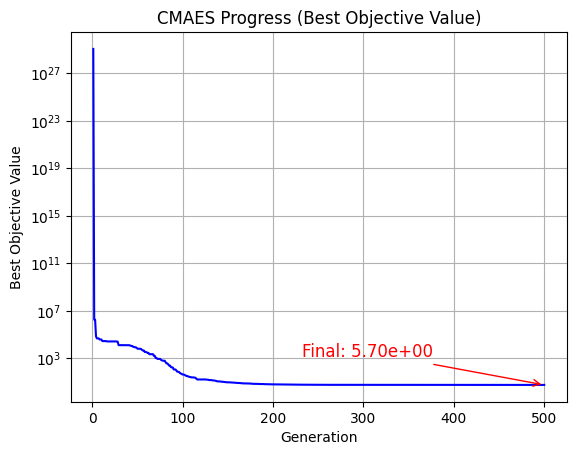

In [96]:
# Only run the optimization, do not print x_best, fit
x_best, fit = run_optimization(result_avg,pop_size=50,n_iter=500, algorithm_name="CMAES",weight=False)

In [97]:
print("Stator parameters")
print(f"Kh = {x_best[0]:.2e}")
print(f"Ke = {x_best[1]:.2e}")
print(f"alpha = {x_best[2]:.2e}")
print(f"beta  = {x_best[3]:.2e}")
print(f"gamma = {x_best[4]:.2e}")
print(f"delta = {x_best[5]:.2e}")

Stator parameters
Kh = 2.81e-04
Ke = 2.36e-02
alpha = 1.74e+00
beta  = 1.70e+00
gamma = 1.53e+00
delta = 9.84e-01


## Optimization PostProcessing

7


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


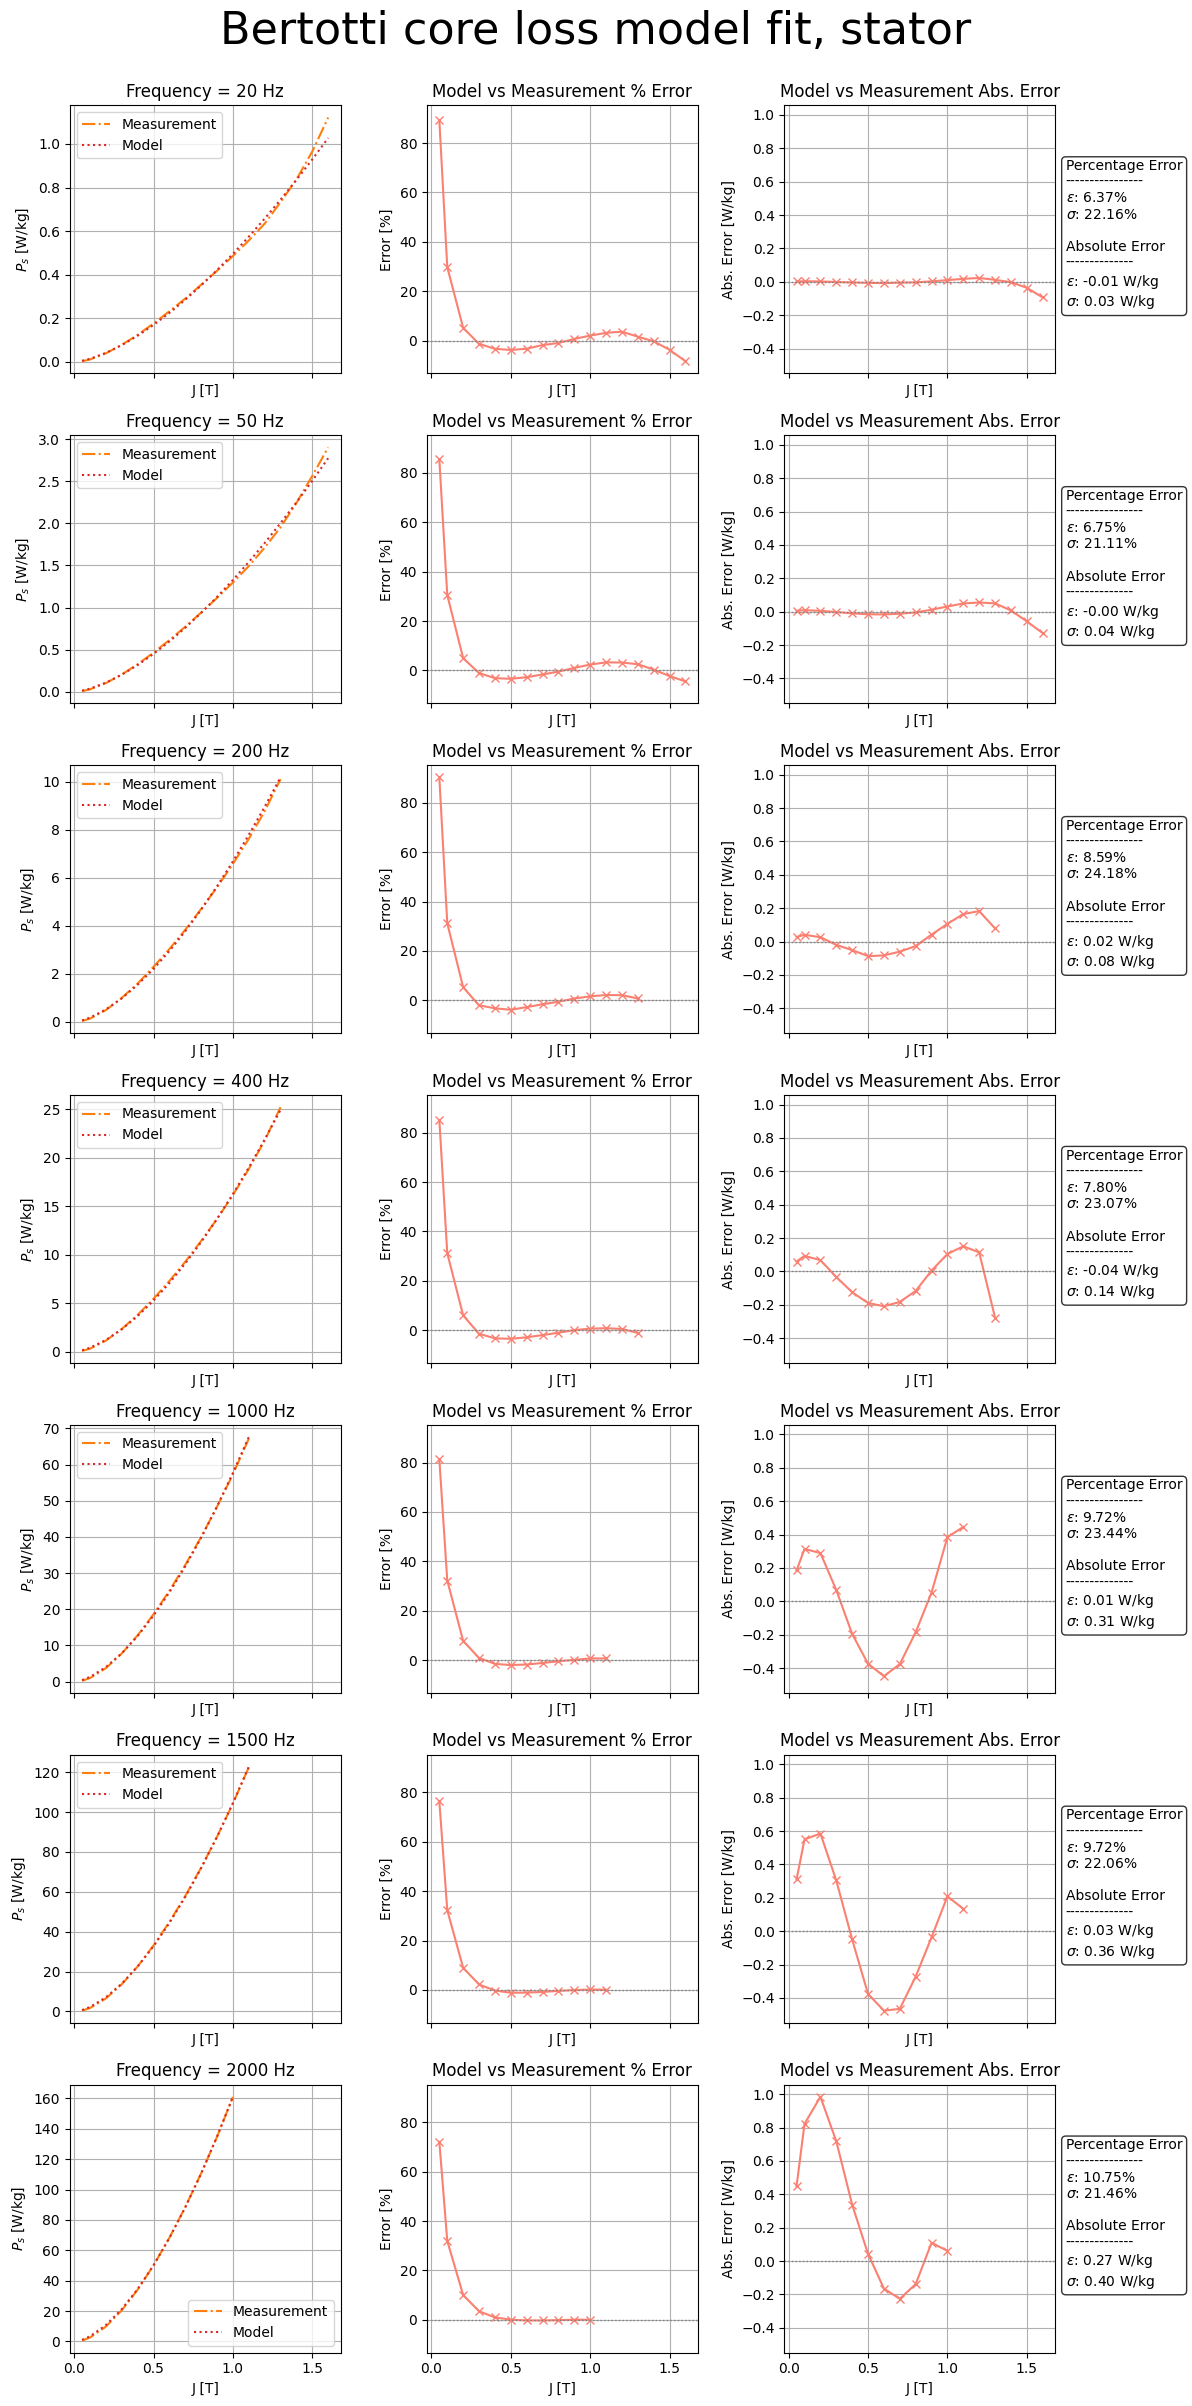

In [115]:
def postProc(x_best, res, plottitle):
    kh, ke, alpha, beta, gamma, delta = x_best              

    # Make 3 subplots, but place a single textbox outside to the right with headers
    # Stack subplots for all frequencies vertically
    # Ensure array
    res = np.asarray(res)

    # Unique freqs (sorted), robust to float comparisons
    freqs = np.unique(res[:, 1])
    n_freqs = len(freqs)
    print(n_freqs)

    # Always get a 2-D axes array
    fig, axs = plt.subplots(n_freqs, 3, figsize=(12, 3.5 * n_freqs), squeeze=False, sharex=True )
    # leave room on the right for the per-row textbox
    fig.subplots_adjust(right=0.78, wspace=0.35, hspace=0.45)
    
    # Pick a reference axis in the "right block" (col 1 is middle)
    ref = axs[0, 1]
    ref2 = axs[0, 2]

    # Make all axes in columns 1 and 2 share y with the reference
    for r in range(n_freqs):
        axs[r, 1].sharey(ref)
        axs[r, 2].sharey(ref2)

    for f_idx, f_el in enumerate(freqs):
        # mask for this frequency (use isclose to avoid float equality issues)
        mask = np.isclose(res[:, 1], f_el)
        J = res[mask, 0]
        f = res[mask, 1]
        meas = res[mask, 2]
        
       # Model
        pm = kh * (J ** alpha) * (f ** beta) + ke * (J ** gamma) * (f ** delta)
    
        # Errors
        perc_error = 100 * (pm - meas) / meas
        abs_error  = (pm - meas)

        # Left: Model vs Measurement
        ax = axs[f_idx, 0]
        if plottitle == 'stator':
            ax.plot(J, meas, label='Measurement', ls='dashdot', c='tab:orange')
        elif plottitle == 'datasheet':
            ax.plot(J, meas, label='Measurement', ls='dashed', c='tab:green')
        else:
            ax.plot(J, meas, label='Measurement')
        ax.plot(J, pm, label='Model', linestyle='dotted', c='tab:red')
        ax.set_title(f'Frequency = {f_el:.0f} Hz')
        ax.legend()
        ax.set_xlabel('J [T]')
        ax.set_ylabel(r'$P_s$ [W/kg]')
        ax.grid(True)

        # Middle: Percentage error
        ax = axs[f_idx, 1]
        ax.plot(J, perc_error, marker='x', c='salmon')
        ax.set_xlabel('J [T]')
        ax.set_ylabel('Error [%]')
        ax.set_title('Model vs Measurement % Error')
        ax.axhline(0, linestyle='dotted', linewidth=1, color='gray')
        ax.grid(True)

        # Right: Absolute error
        ax = axs[f_idx, 2]
        ax.plot(J, abs_error, marker='x', c='salmon')
        ax.set_xlabel('J [T]')
        ax.set_ylabel('Abs. Error [W/kg]')
        ax.set_title('Model vs Measurement Abs. Error')
        ax.axhline(0, linestyle='dotted', linewidth=1, color='gray')
        ax.grid(True)

        # Summary textbox in axes coords
        textstr = (
            "Percentage Error\n"
            "----------------\n"
            r"$\epsilon$: {:.2f}%".format(np.mean(perc_error)) + "\n"
            r"$\sigma$: {:.2f}%".format(np.std(perc_error)) + "\n\n"
            "Absolute Error\n"
            "--------------\n"
            r"$\epsilon$: {:.2f} W/kg".format(np.mean(abs_error)) + "\n"
            r"$\sigma$: {:.2f} W/kg".format(np.std(abs_error))
        )
        ax.text(
            1.04, 0.8, textstr,
            transform=ax.transAxes, va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            clip_on=False  # <-- allow drawing outside the axes
        )

    fig.suptitle(f'Bertotti core loss model fit, {plottitle}', fontsize=32)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(f'figures/png/{plottitle}.png', dpi=600)
    plt.savefig(f'figures/svg/{plottitle}.svg')
    plt.savefig(f'figures/eps/{plottitle}.eps')

    plt.show()

postProc(x_best, result_avg, 'stator')




# BUILD FACTOR CALCULATION

In [99]:
# Extract from excel and concatenate all sheets
file_path = "LAMS/hiliteno20-1200h.xlsx"
data_sample = pd.read_excel(file_path, None)

# Display sheet names for the file
sheet_names = list(data_sample.keys())
print("Sheet names:", sheet_names)

# Concatenate all sheets into a single DataFrame
all_data_concat = pd.concat(data_sample.values(), ignore_index=True)

# Swap the second and third columns
cols = list(all_data_concat.columns)
cols[1], cols[2] = cols[2], cols[1]
all_data_swapped = all_data_concat[cols].copy()

# Convert the first three columns to float
for col in all_data_swapped.columns[:3]:
    all_data_swapped[col] = pd.to_numeric(all_data_swapped[col], errors='coerce')

# Convert the first three columns of all_data_swapped to a numpy array
all_data_np = all_data_swapped.iloc[:, :3].dropna().astype(float).values



Sheet names: ['Frequency_50Hz', 'Frequency_100Hz', 'Frequency_200Hz', 'Frequency_400Hz', 'Frequency_700Hz', 'Frequency_1000Hz']


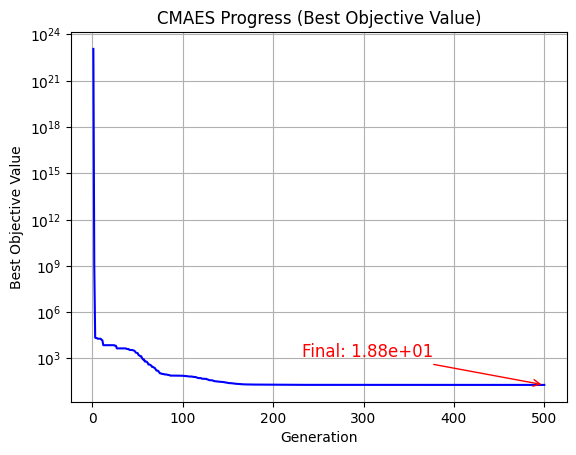

Epstein frame parameters
Kh = 7.22e-04
Ke = 1.36e-03
alpha = 4.66e+00
beta  = 1.24e+00
gamma = 1.64e+00
delta = 1.48e+00


In [100]:
x_EF, fit_EF = run_optimization(all_data_np,pop_size=100,n_iter=500, algorithm_name="CMAES",weight=False)

print("Epstein frame parameters")
print(f"Kh = {x_EF[0]:.2e}")
print(f"Ke = {x_EF[1]:.2e}")
print(f"alpha = {x_EF[2]:.2e}")
print(f"beta  = {x_EF[3]:.2e}")
print(f"gamma = {x_EF[4]:.2e}")
print(f"delta = {x_EF[5]:.2e}")



6


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


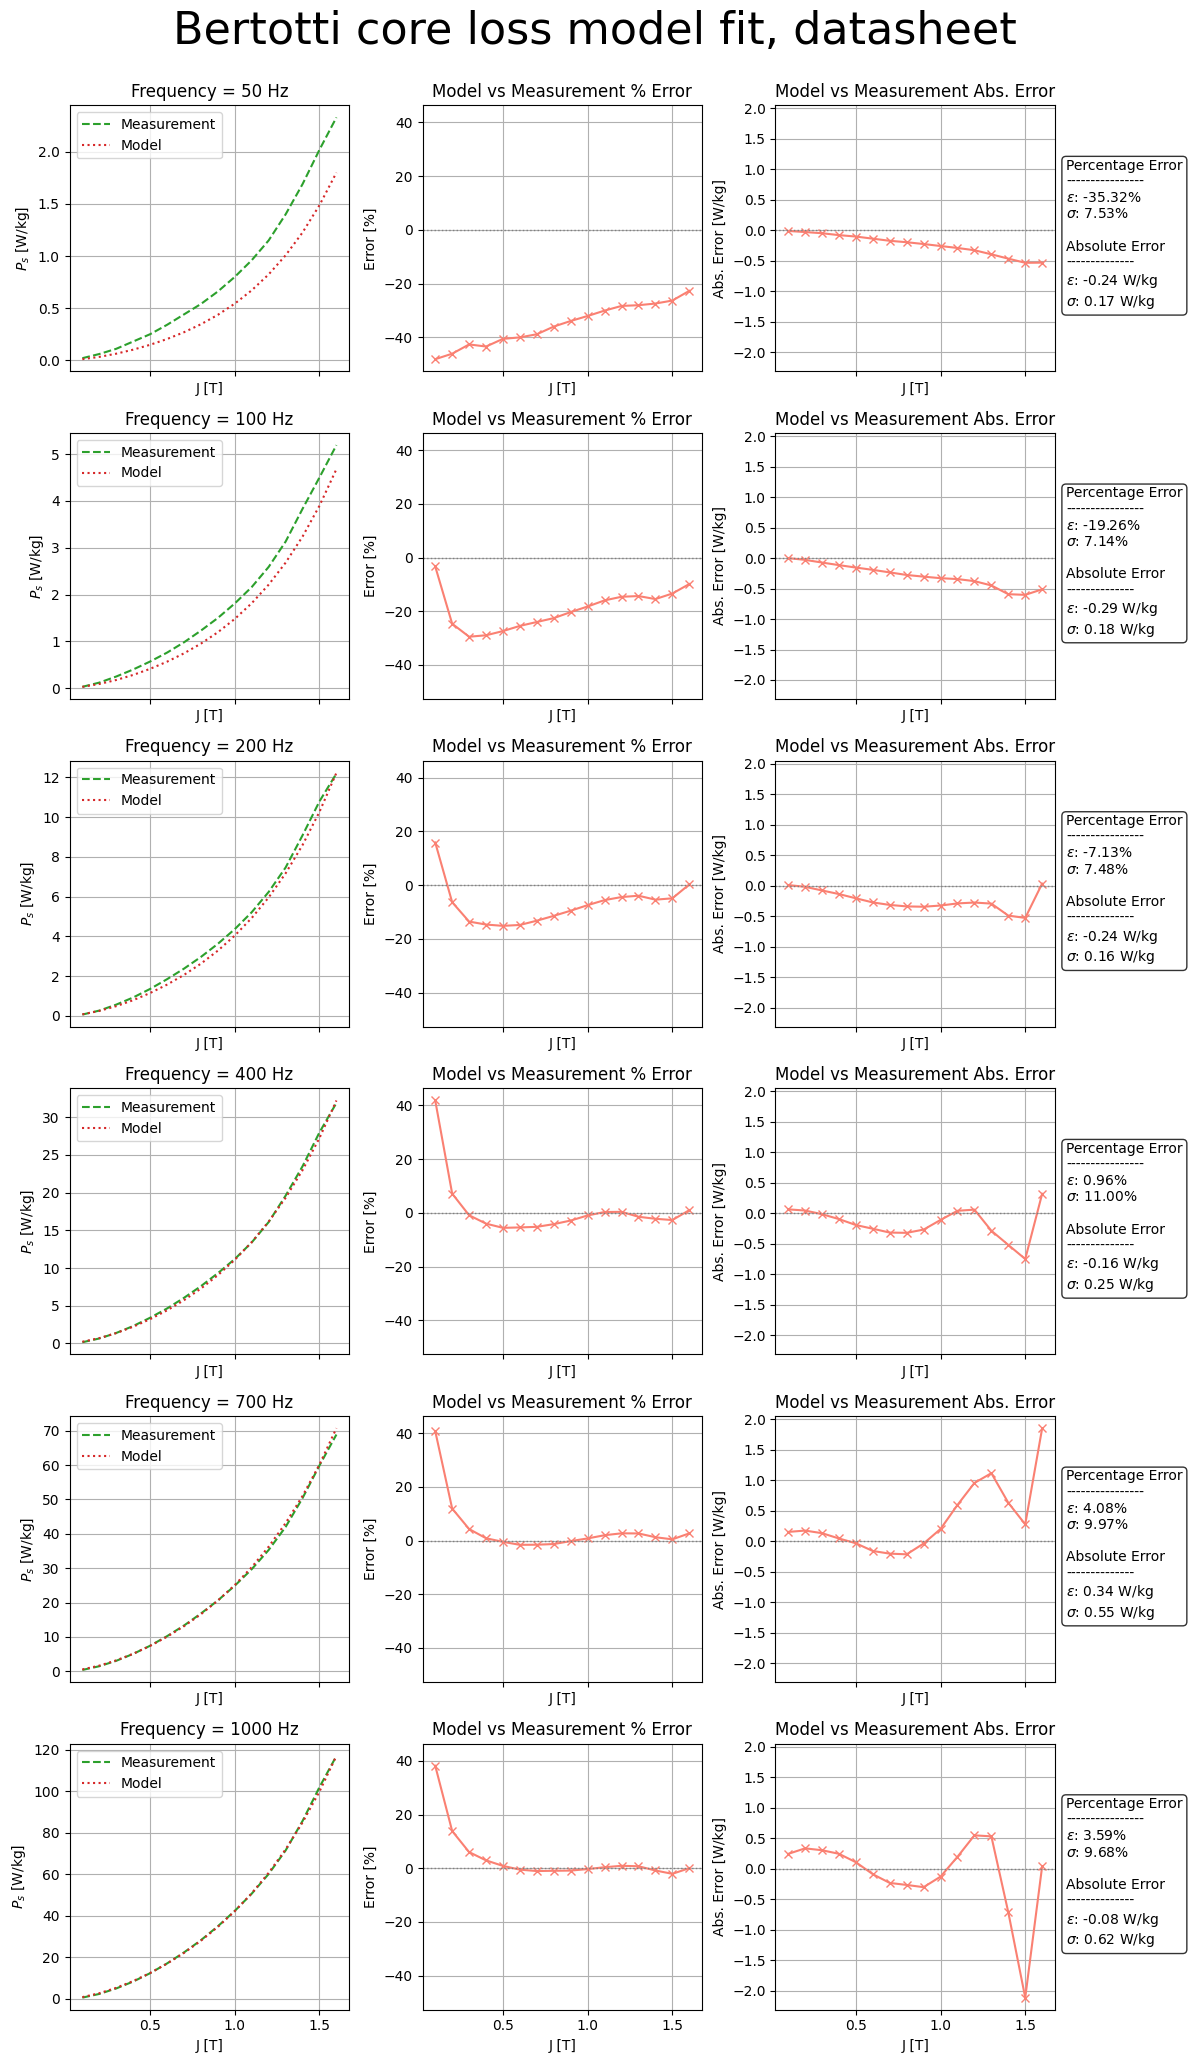

In [116]:
postProc(x_EF, all_data_np, 'datasheet')

1


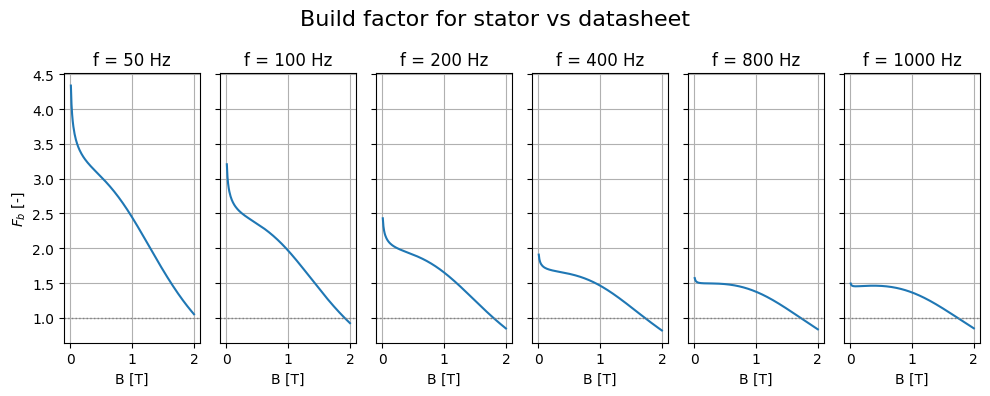

In [103]:
import math
# define frequencies and induction to be evaluated
fel_build = [50, 100, 200, 400, 800, 1000]
B = np.arange(0.01, 2 + 0.01, 0.01)

n = len(fel_build)
ncols = 6
nrows = math.ceil(n / ncols)
print(nrows)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 4*nrows), sharex=True, sharey=True)

for i, val in enumerate(fel_build):
    p_EF = x_EF[0] * B ** x_EF[2] * fel_build[i] ** x_EF[3] + x_EF[1] * B ** x_EF[4] * fel_build[i] ** x_EF[5]
    p_stat = x_best[0] * B ** x_best[2] * fel_build[i] ** x_best[3] + x_best[1] * B ** x_best[4] * fel_build[i] ** x_best[5]

    if nrows == 1:
        ax = axs[i % ncols]
    else:   
        ax = axs[i // ncols, i % ncols]
    ax.set_title(f"f = {val} Hz")
    ax.plot(B, p_stat/p_EF)
    ax.axhline(1, linestyle='dotted', linewidth=1, color='gray')

    ax.set_xlabel('B [T]')
    if i % ncols == 0:
        ax.set_ylabel(r'$F_b$ [-]')
    ax.grid(True)
    ax.set_xlim(-0.1, 2.1)

plt.suptitle('Build factor for stator vs datasheet', fontsize=16)
plt.tight_layout()
plt.savefig('figures/svg/build_factors_no20-1200h.svg')
plt.savefig('figures/png/build_factors_no20-1200h.png', dpi=600)
plt.savefig('figures/eps/build_factors_no20-1200h.eps')
plt.show()